In [12]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


In [13]:
# Load the dataset from the Excel file (sheet "Usage" has the raw usage data)
df = pd.read_excel('data_cleaning.xlsx', sheet_name='Usage', header=None)

# Rename the column to 'unclean_data' for clarity
df = df.rename(columns={0: 'unclean_data'})

# Convert text to lowercase and strip whitespace to standardize the format
df['unclean_data'] = df['unclean_data'].str.lower().str.strip()

# Peek at the first few rows to see the raw format
print(df['unclean_data'].head(5))

0        3 pm  mon 24th-mar-2014___0.384 kwh
1              5am  15-aug-2014___1.201  kwh
2         __8pm thu 20-mar-2014____1.523 kwh
3            6pm  23rd-apr-2014___0.424  kwh
4    _1am  friday 19th-dec-2014___0.209  kwh
Name: unclean_data, dtype: object


In [14]:
# Use regex to extract the hour (numeric part) from the string (allows leading spaces/underscores before the number)
pattern_hours = re.compile(r"(?:[\s\_]*)(\d+)")
df['hours'] = df['unclean_data'].str.extract(pattern_hours)

# Extract the "am" or "pm" part of the time
pattern_am_pm = re.compile(r"(am|pm)")
df['am_pm'] = df['unclean_data'].str.extract(pattern_am_pm)

# Extract the day, month, and year from the date portion of the string
date_pattern = re.compile(r"(\d{1,2})\w*-(\w+)-(\d{4})")
date_components = df['unclean_data'].str.extract(date_pattern)
# The above gives a DataFrame with three columns: day, month, year
df['day'] = date_components[0]   # day of month (as string)
df['month'] = date_components[1] # month abbreviation/name
df['year'] = date_components[2]  # year

# Extract the kWh usage value. The pattern looks for one or more underscores, then the number (with decimal), followed by 'kwh'
kwh_pattern = re.compile(r"\_+(\d+\.\d+)\s*kwh")
df['kwh'] = df['unclean_data'].str.extract(kwh_pattern).astype(float)

# Check the extracted components for the first few rows
print(df[['hours', 'am_pm', 'day', 'month', 'year', 'kwh']].head(5))


  hours am_pm day month  year    kwh
0     3    pm  24   mar  2014  0.384
1     5    am  15   aug  2014  1.201
2     8    pm  20   mar  2014  1.523
3     6    pm  23   apr  2014  0.424
4     1    am  19   dec  2014  0.209


In [15]:
# Combine day, month, year, hour, and am/pm into one string to parse as datetime (e.g., "24mar20143pm")
df['datetime_str'] = df['day'] + df['month'] + df['year'] + df['hours'] + df['am_pm']

# Convert the combined string to a datetime object
df['datetime'] = pd.to_datetime(df['datetime_str'], format='%d%b%Y%I%p')

# Drop the temporary datetime string column
df.drop(columns=['datetime_str'], inplace=True)

# Sort by datetime to ensure chronological order for time-series analysis
df = df.sort_values('datetime').reset_index(drop=True)

# Create a 'weekday' column with the day-of-week name, using an ordered category to preserve natural order
df['weekday'] = pd.Categorical(df['datetime'].dt.day_name(),
                               categories=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
                               ordered=True)

# Verify the new datetime and weekday columns
print(df[['datetime', 'weekday', 'kwh']].head(3))


             datetime    weekday    kwh
0 2014-01-01 00:00:00  Wednesday  0.684
1 2014-01-01 01:00:00  Wednesday  0.340
2 2014-01-01 02:00:00  Wednesday  0.332


In [16]:
# Overall average electricity usage (in kWh)
overall_avg = df['kwh'].mean()

# Average usage in February (month "feb")
feb_avg = df[df['month'] == 'feb']['kwh'].mean()

# Day of the week with the highest average usage
avg_by_weekday = df.groupby('weekday')['kwh'].mean()  # average usage for each weekday
highest_day = avg_by_weekday.idxmax()   # weekday name with highest average usage
highest_day_val = avg_by_weekday.max()  # the value of the highest average usage

# Highest total usage over any rolling 4-hour window
# (We use rolling sum with window=4 on the sorted data)
rolling_4h = df['kwh'].rolling(window=4).sum()
max_4h_usage = rolling_4h.max()

# Print out the results with proper formatting
print(f"Overall average usage: {overall_avg:.3f} kWh")
print(f"Average usage in February: {feb_avg:.3f} kWh")
print(f"Highest average usage by day of week: {highest_day} ({highest_day_val:.3f} kWh)")
print(f"Maximum total usage in any 4-hour period: {max_4h_usage:.3f} kWh")


Overall average usage: 0.782 kWh
Average usage in February: 0.834 kWh
Highest average usage by day of week: Sunday (0.899 kWh)
Maximum total usage in any 4-hour period: 17.237 kWh


C:\Users\user\AppData\Local\Temp\ipykernel_18448\1231549025.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_weekday = df.groupby('weekday')['kwh'].mean()  # average usage for each weekday


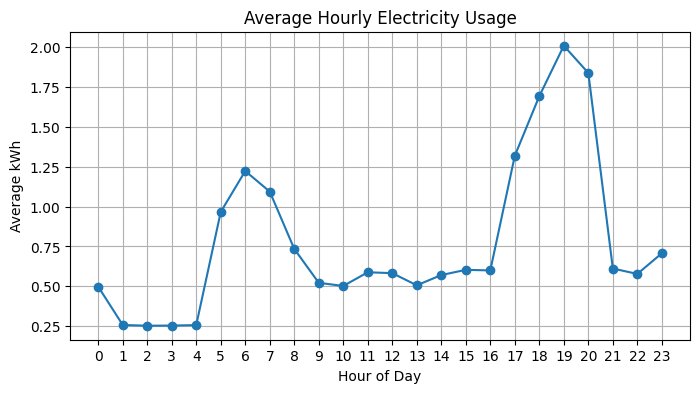

In [17]:
# Calculate the average usage for each hour of the day (0 through 23)
avg_by_hour = df.groupby(df['datetime'].dt.hour)['kwh'].mean()

# Plot the average usage by hour of day
hours = avg_by_hour.index  # Hour values (0-23)
usage_values = avg_by_hour.values

plt.figure(figsize=(8, 4))
plt.plot(hours, usage_values, marker='o')
plt.title('Average Hourly Electricity Usage')
plt.xlabel('Hour of Day')
plt.ylabel('Average kWh')
plt.xticks(ticks=range(0, 24, 1))  # show every hour on the x-axis (0,1,2,...23)
plt.grid(True)
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_18448\1470691601.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_weekday = df.groupby('weekday')['kwh'].mean()


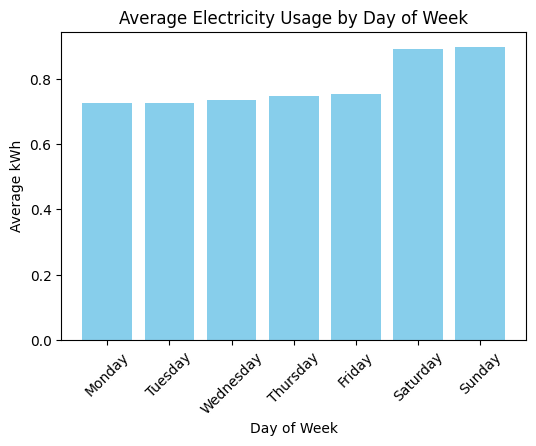

In [18]:
# Calculate the average usage for each day of the week
avg_by_weekday = df.groupby('weekday')['kwh'].mean()

# Prepare data for plotting
days = avg_by_weekday.index.tolist()  # ['Monday', 'Tuesday', ..., 'Sunday']
usage_by_day = avg_by_weekday.values

plt.figure(figsize=(6, 4))
plt.bar(days, usage_by_day, color='skyblue')
plt.title('Average Electricity Usage by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average kWh')
plt.xticks(rotation=45)  # rotate day labels for readability (if needed)
plt.show()


In [19]:
# Load contract pricing details (from sheet "Contracts")
contracts = pd.read_excel('data_cleaning.xlsx', sheet_name='Contracts')

In [20]:
# Extract and clean Monthly Flex contract data
monthly_flex_data = contracts.iloc[9:23, [4, 5]].dropna().reset_index(drop=True)
monthly_flex_data.columns = ['Month', 'Rate']
monthly_flex_data['Month'] = monthly_flex_data['Month'].str.strip()
monthly_flex_data['Rate'] = monthly_flex_data['Rate'].astype(float)

In [21]:
# Compute total electricity usage per month
df['month_new'] = df['datetime'].dt.strftime('%B')  # Extract month names for analysis
month_for_calculation = df.groupby('month_new')['kwh'].sum().reset_index()
month_for_calculation.columns = ['Month', 'kwh']

# Merge electricity usage with contract rates and calculate total cost for Monthly Flex plan
merged_df = pd.merge(monthly_flex_data, month_for_calculation, on='Month')
merged_df['result'] = merged_df['kwh'] * merged_df['Rate']
monthly_flex_usage = merged_df['result'].sum()

In [23]:
# Extract and clean Hourly Flex contract data
hourly_flex_data = contracts.iloc[11:35, [8, 9]].dropna().reset_index(drop=True)
hourly_flex_data.columns = ['hour', 'Rate']
hourly_flex_data['hour'] = hourly_flex_data['hour'].astype(str).str.strip().str.zfill(2)
hourly_flex_data['Rate'] = hourly_flex_data['Rate'].astype(float)
hourly_flex_data

,hour,Rate
0,12AM until 1AM,0.10
1,1AM until 2AM,0.10
2,2AM until 3AM,0.10
3,3AM until 4AM,0.10
4,4AM until 5AM,0.15
5,5AM until 6AM,0.20
6,6AM until 7AM,0.24
7,7AM until 8AM,0.24
8,8AM until 9AM,0.26
9,9AM until 10AM,0.20


In [24]:
# Merge electricity usage with hourly rates and compute total cost for Hourly Flex plan
df['hour'] = df['datetime'].dt.strftime('%I')
merged_hourly_df = pd.merge(hourly_flex_data, df, on='hour')
hourly_flex_usage = (merged_hourly_df['Rate'] * merged_hourly_df['kwh']).sum()

# Compute total cost for No Flex plan (fixed rate of $0.21 per kWh)
no_flex_usage = float(df['kwh'].sum() * 0.21)

In [25]:
# Determine the lowest cost plan
plans = {
    no_flex_usage: "The No Flex Plan",
    monthly_flex_usage: "The Monthly Flex Plan",
    hourly_flex_usage: "The Hourly Flex Plan",
}
lowest_plan = plans[min(no_flex_usage, monthly_flex_usage, hourly_flex_usage)]

# Display insights
print(f"Monthly Flex Plan Cost: ${monthly_flex_usage:.2f}")
print(f"Hourly Flex Plan Cost: ${hourly_flex_usage:.2f}")
print(f"No Flex Plan Cost: ${no_flex_usage:.2f}")
print(f"Best Plan (Lowest Cost): {lowest_plan}")

Monthly Flex Plan Cost: $1421.21
Hourly Flex Plan Cost: $0.00
No Flex Plan Cost: $1438.10
Best Plan (Lowest Cost): The Hourly Flex Plan
